<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.4 MB/s eta 0:00:00


In [27]:
from pandas.errors import SettingWithCopyWarning
from time import time as get_time
from transformers import pipeline
from shapely import Point
from tqdm import tqdm

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import warnings
import folium

In [20]:
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [3]:
FOOD = {'restaurant','fast_food','cafe'}
FOOD

{'cafe', 'fast_food', 'restaurant'}

In [4]:
place = "Paris, France"

tags = {"amenity": True}

In [5]:
START = get_time()

pois = ox.features_from_place(place, tags)

END = get_time()

In [6]:
pois = pois[['name', 'amenity', 'geometry']].dropna().rename(columns={'amenity':'place_type'}).to_crs("EPSG:32631")
pois['IsFood'] = pois.place_type.apply(lambda value: value in FOOD)
print(f'Time to extarct data from OSM: {round(END-START,1)} seconds ({round((END-START)/60,1)} minutes)\n\n')

pois.shape

Time to extarct data from OSM: 86.8 seconds (1.4 minutes)




(26498, 4)

In [7]:
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  
element id                                                
node    21662099  POINT (452320.712 5411188.723)   False  
        24910582  POINT (445834.511 5412487.964)   False  
        25213384  POINT (446146.834 5409337.476)   False  
        25214653  POINT (453864.466 5414327.112)   False  
        27415802  POINT (448842.707 5414715.887)   False

In [8]:
is_food_rate = round(pois.IsFood.mean()*100,1)

print(f'{is_food_rate}% of POIs place_type are "Food related" (place_type = {FOOD})')


52.5% of POIs place_type are "Food related" (place_type = {'fast_food', 'cafe', 'restaurant'})


In [9]:
pois.place_type.value_counts().head(10)

,count
place_type,
restaurant,8757
fast_food,2754
cafe,2408
bar,1799
school,1234
bicycle_rental,1052
bank,912
pharmacy,874
social_facility,461


In [10]:
MODEL = "intfloat/multilingual-e5-large"

TEXT = "restaurant"

embedder = pipeline("feature-extraction", model=MODEL)

get_text_embedding = lambda text: np.array(embedder(text)[0]).max(0)

get_text_embedding(TEXT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


array([ 1.23215389,  0.75919461, -0.2232188 , ..., -0.21436594,
       -0.850609  ,  1.06850421])

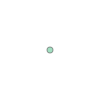

In [46]:
# Eiffel Tower ("Tour Eiffel")

# WGS84 GEO DD X = 2.2944492, Y = 48.8583088
# WGS84 GEO UTM 31N X = 448248, Y = 5411944



EIFFEL = Point(448248, 5411944)
EIFFEL

# # !pip install utm
# from utm import from_latlon

# from_latlon(48.8583088,2.2944492)

In [53]:

eiffecl_wgs84_dd = gpd.GeoSeries([EIFFEL], crs="EPSG:32631").to_crs("EPSG:4326").iloc[0]

eiffel_x, eiffel_y = eiffecl_wgs84_dd.x, eiffecl_wgs84_dd.y

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=15, width=1500, height=500)
folium.Marker([eiffel_y,eiffel_x], popup="Tour Eiffel", tooltip="Tour Eiffel").add_to(fmap)
fmap





In [12]:
pois['distance_from_eiffel'] = pois.geometry.distance(EIFFEL).round(2)
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  distance_from_eiffel  
element id                                                                      
node    21662099  POINT (452320.712 5411188.723)   False               4077.22  
        24910582  POINT (445834.511 5412487.964)   False               2538.37  
        25213384  POINT (446146.834 5409337.476)   False               3394.26  
        25214653  POINT (453864.466 5414327.112)   False               6037.55  
        27415802  POINT (448842.707 5414715.887)   False               2816.76

In [13]:
eiffel_radius = pois[pois['distance_from_eiffel']<2000]
eiffel_radius.shape

(2528, 5)

In [14]:
eiffel_radius['repr'] = [get_text_embedding(text) for text in tqdm(eiffel_radius.name)]

eiffel_radius.head()

100%|██████████| 2528/2528 [00:44<00:00, 57.29it/s]
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


name        place_type  \
element id                                                                
node    29434739                Paris École Militaire       post_office   
        241110355              Bibliothèque Vaugirard           library   
        241110562  Parking Lecourbe - Mairie du XVème  parking_entrance   
        243842886     Parking Quai branly-Tour Eiffel           parking   
        251758250                               Qasim        restaurant   

                                         geometry  IsFood  \
element id                                                  
node    29434739   POINT (449155.089 5411637.554)   False   
        241110355  POINT (448589.838 5410098.839)   False   
        241110562  POINT (448613.402 5410068.739)   False   
        243842886  POINT (448586.566 5412289.977)   False   
        251758250  POINT (449359.156 5413350.384)    True   

                   distance_from_eiffel  \
element id                                
node    29434739                 895.96   
        241110355               1870.46   
        241110562               1903.79   
        243842886                435.91   
        251758250               1747.61   

                                                                repr  
element id                                                            
node    29434739   [0.7380602359771729, 0.4176127314567566, 0.588...  
        241110355  [0.7727096080780029, 0.5499468445777893, 0.106...  
        241110562  [1.3283438682556152, 0.2236246019601822, 0.116...  
        243842886  [1.5052865743637085, 0.5771607756614685, 0.333...  
        251758250  [2.1504743099212646, 1.3921866416931152, -0.49...

In [21]:
food = get_text_embedding("I want something to eat")

cosine_similarity = lambda vec1, vec2: np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

eiffel_radius['L2'] = eiffel_radius.repr.apply(lambda ary: ((food-ary)**2).mean())
eiffel_radius['L1'] = eiffel_radius.repr.apply(lambda ary:  np.abs(food-ary).mean())
eiffel_radius['CS'] = eiffel_radius.repr.apply(lambda ary:  1-cosine_similarity(food,ary))
eiffel_radius['Random'] = np.random.rand(eiffel_radius.shape[0])

eiffel_radius.head()

name        place_type  \
element id                                                                
node    29434739                Paris École Militaire       post_office   
        241110355              Bibliothèque Vaugirard           library   
        241110562  Parking Lecourbe - Mairie du XVème  parking_entrance   
        243842886     Parking Quai branly-Tour Eiffel           parking   
        251758250                               Qasim        restaurant   

                                         geometry  IsFood  \
element id                                                  
node    29434739   POINT (449155.089 5411637.554)   False   
        241110355  POINT (448589.838 5410098.839)   False   
        241110562  POINT (448613.402 5410068.739)   False   
        243842886  POINT (448586.566 5412289.977)   False   
        251758250  POINT (449359.156 5413350.384)    True   

                   distance_from_eiffel  \
element id                                
node    29434739                 895.96   
        241110355               1870.46   
        241110562               1903.79   
        243842886                435.91   
        251758250               1747.61   

                                                                repr  \
element id                                                             
node    29434739   [0.7380602359771729, 0.4176127314567566, 0.588...   
        241110355  [0.7727096080780029, 0.5499468445777893, 0.106...   
        241110562  [1.3283438682556152, 0.2236246019601822, 0.116...   
        243842886  [1.5052865743637085, 0.5771607756614685, 0.333...   
        251758250  [2.1504743099212646, 1.3921866416931152, -0.49...   

                         L2        L1        CS    Random  
element id                                                 
node    29434739   0.472155  0.549817  0.243712  0.380501  
        241110355  0.447244  0.537225  0.231371  0.520144  
        241110562  0.464554  0.534237  0.232231  0.429707  
        243842886  0.445518  0.532689  0.222184  0.347264  
        251758250  0.505318  0.560433  0.261883  0.369219

In [16]:

Ks = [5, 10, 25, 50, 75, 100, 200, 1000, len(eiffel_radius)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100
evaluation.round(1)


,L2,L1,CS,Random,distance_from_eiffel
5,100.0,100.0,100.0,60.0,60.0
10,100.0,100.0,100.0,60.0,40.0
25,92.0,100.0,96.0,56.0,48.0
50,96.0,96.0,96.0,52.0,50.0
75,97.3,96.0,97.3,58.7,49.3
100,95.0,95.0,98.0,57.0,52.0
200,90.0,91.5,89.0,53.5,54.0
1000,64.4,64.7,62.2,49.3,52.0
2528,49.6,49.6,49.6,49.6,49.6


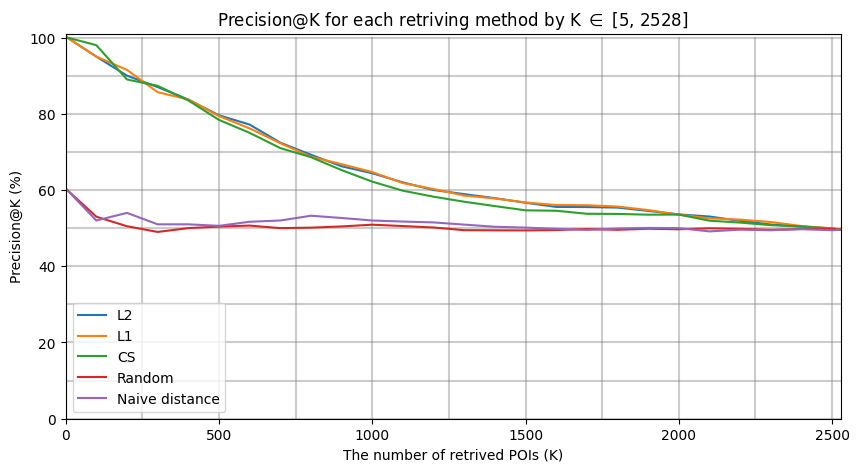

In [25]:
Ks = [5]+[*range(100, len(eiffel_radius), 100)]+[len(eiffel_radius)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100

# ##############################################################################

plt.figure(figsize=(10,5))
plt.title(f'Precision@K for each retriving method by K $\\in$ [5, {len(eiffel_radius)}]')
for col in evaluation.columns:

    plt.plot(evaluation.index, evaluation[col], label=col if col!='distance_from_eiffel' else 'Naive distance')

for yi in np.linspace(0,100,11):
    plt.plot([0,len(eiffel_radius)],[yi,yi], color='gray', alpha=.4, zorder=-1)

for xi in np.arange(0,len(eiffel_radius),250):
    plt.plot([xi, xi],[0,100], color='gray', alpha=.4, zorder=-1)

plt.xlabel('The number of retrived POIs (K)')
plt.ylabel('Precision@K (%)')

plt.legend(loc='lower left')
plt.ylim(0,101)
plt.xlim(0,len(eiffel_radius))

plt.show()

